### Kaggle Problem

https://www.kaggle.com/c/santander-customer-transaction-prediction

### Setup

In [15]:
!free --mega

              total        used        free      shared  buff/cache   available
Mem:          61406         463       58018           8        2924       60382
Swap:             0           0           0


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [88]:
import numpy as np
import pandas as pd
import zipfile
import os
import xgboost as xgb
from dfply import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, log_loss, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import forest

In [11]:
PATH = "data/"

In [12]:
!ls {PATH}

In [13]:
! pwd

/home/ubuntu/DS_Explorations/Santander


### Read data

In [14]:
#Training data
! wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle/10385/298493/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1556624842&Signature=G05GOXae1k7mGHMixP0UoDd5ZGCHrhzvAaWelGfaWi1%2FumdUPaNJbv5VZX8LQw6XTcWLk316h6NgspnIlVsotE%2BauAPHkWo6QmfxmMO7OU44EaS1f%2Bl%2Fa7aIQcG1PoGWKOMD07ZNv%2BEErSf4isTkp%2B7T5n%2FT%2B1G6QNc2oj8nkT2RULz239WyMD6n1uQcGw44Zlso%2BYXJc1DKJGuJETFNiVuMNK1LnslGUX77l3%2FWODPnOtegEyrM9ocT9DD3mEf0dWewI98y9Pjq%2FFyFAezV%2Fy76496PYFlzdezu75HMi5PiwlDtth3t62H0HFHfoOEszMjMputDpgkC1NnxYqurvA%3D%3D" -O "data/train.csv.zip" -c
#Test data
! wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle/10385/298493/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1556624935&Signature=DJ2WqgI2BtPepY2Ucm9hGbeye9Wn%2BwL%2BPxCoh3r1ifsMNsESjrM4a72koVpys2k1dEedQGpkN7J4GMfwgiprwrULWSpCirFX5gtnkBYuNT4MCS0Zch9nKJK7v6DoT6Qzse%2BI5ub849JZlLaEiF8kWUPCluOMrsUv2yFl3Ilyw9XFBEMKg5PaGmvjgEFnWH0%2B2OsR1CodVWM3SqszNgcPy9bAut%2FZmkaRzJybo9tAexCjjku%2Bn4ZooYILlO9Qo8jqVBVoQedWQwI3EKgeWJT3RFxLuuowqMXI42jXRCYZ9xOdApuhevPacweMqcMZ3K85W7SwfS%2F%2BSiPKPHc4pdSNTw%3D%3D" -O "data/test.csv.zip" -c
#Sample Sumbmission
#! wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.109 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle/10385/298493/sample_submission.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1552187196&Signature=QDaMp6tIDzk4xI%2Fv%2BWSolDzWPAoohTu4UpG7A2v8z6CLdsW4YYDKaosJfXzJOPHs25ufGXIX6c%2B9WSJq7voLjB5eTyHHyteGiDDNMQW4VS9p9iuLfV4aU2p87WGDjHBZgej5sRio2zPm4P2Pg9G3ID5l3BZ0U2MLWDcHVJnBpT4wh3zhUtn%2BFfiXYpxaj79ouma1XTaUWS0VQO%2B6p1%2BUya22P4319%2Bf9z2xM74m6jIDJuDk4ctZC5gl4PLJRT5BzBmbo71IWCKD2YUlSpFyew1alb5RjjurLU3V3pfWYoF1y4S6zQbqE%2B59Srz6WcB8OrP1AlVxfvt51T6WGoB%2Ft2Q%3D%3D" -O "data/sample_submission.csv.zip" -c

--2019-04-27 11:50:19--  https://storage.googleapis.com/kaggle-competitions-data/kaggle/10385/298493/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1556624842&Signature=G05GOXae1k7mGHMixP0UoDd5ZGCHrhzvAaWelGfaWi1%2FumdUPaNJbv5VZX8LQw6XTcWLk316h6NgspnIlVsotE%2BauAPHkWo6QmfxmMO7OU44EaS1f%2Bl%2Fa7aIQcG1PoGWKOMD07ZNv%2BEErSf4isTkp%2B7T5n%2FT%2B1G6QNc2oj8nkT2RULz239WyMD6n1uQcGw44Zlso%2BYXJc1DKJGuJETFNiVuMNK1LnslGUX77l3%2FWODPnOtegEyrM9ocT9DD3mEf0dWewI98y9Pjq%2FFyFAezV%2Fy76496PYFlzdezu75HMi5PiwlDtth3t62H0HFHfoOEszMjMputDpgkC1NnxYqurvA%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.217.48, 2607:f8b0:400a:809::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.217.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128240759 (122M) [application/zip]
Saving to: ‘data/train.csv.zip’

data/train.csv.zip  100%[===================>] 122.30M  59.0MB/s    in 2.1s    

2019-04-27 11:50:21 (

In [16]:
# Current directory
os.getcwd()

'/home/ubuntu/DS_Explorations/Santander'

In [18]:
#Unzip files
dir_name = '/home/ubuntu/DS_Explorations/Santander/data'
extension = ".zip"

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = dir_name + "/" + item
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [19]:
%%time
train_data = pd.read_csv('data/train.csv')#,nrows=1000)

CPU times: user 7.1 s, sys: 540 ms, total: 7.64 s
Wall time: 7.66 s


In [20]:
! free -h

              total        used        free      shared  buff/cache   available
Mem:            59G        1.1G         55G        8.8M        3.2G         58G
Swap:            0B          0B          0B


In [21]:
#Just for display of DF on Notebook
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [22]:
display_all(train_data.head(5).transpose())

,0,1,2,3,4
ID_code,train_0,train_1,train_2,train_3,train_4
target,0,0,0,0,0
var_0,8.9255,11.5006,8.6093,11.0604,9.8369
var_1,-6.7863,-4.1473,-2.7457,-2.1518,-1.4834
var_2,11.9081,13.8588,12.0805,8.9522,12.8746
var_3,5.093,5.389,7.8928,7.1957,6.6375
var_4,11.4607,12.3622,10.5825,12.5846,12.2772
var_5,-9.2834,7.0433,-9.0837,-1.8361,2.4486
var_6,5.1187,5.6208,6.9427,5.8428,5.9405
var_7,18.6266,16.5338,14.6155,14.925,19.2514


In [23]:
#Test data
test_data = pd.read_csv('data/test.csv')#,1000)

In [16]:
#Save in feather format
train_data.to_feather('data/train_data')
test_data.to_feather('data/test_data')

In [28]:
#read from feather
train_data = pd.read_feather('data/train_data')
test_data = pd.read_feather('data/test_data')

/usr/local/lib/python3.6/dist-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


### Data Prep for modelling

In [24]:
train_data.shape

(200000, 202)

In [25]:
test_data.shape

(200000, 201)

In [26]:
display_all(train_data[['target']].isnull().sum()/len(train_data))

target    0.0
dtype: float64

In [27]:
#Columns different in train and test data
print("Variables not in test but in train : ", set(train_data.columns).difference(set(test_data.columns)))

Variables not in test but in train :  {'target'}


In [20]:
#get a sense of indvidual data types
display_all(train_data.dtypes)

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
var_3      float64
var_4      float64
var_5      float64
var_6      float64
var_7      float64
var_8      float64
var_9      float64
var_10     float64
var_11     float64
var_12     float64
var_13     float64
var_14     float64
var_15     float64
var_16     float64
var_17     float64
var_18     float64
var_19     float64
var_20     float64
var_21     float64
var_22     float64
var_23     float64
var_24     float64
var_25     float64
var_26     float64
var_27     float64
var_28     float64
var_29     float64
var_30     float64
var_31     float64
var_32     float64
var_33     float64
var_34     float64
var_35     float64
var_36     float64
var_37     float64
var_38     float64
var_39     float64
var_40     float64
var_41     float64
var_42     float64
var_43     float64
var_44     float64
var_45     float64
var_46     float64
var_47     float64
var_48     float64
var_49     float64
var_50     f

In [21]:
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.

    Parameters:
    -----------
    df: The data frame that will be changed.

    col: The column of data to fix by filling in missing data.

    name: The name of the new filled column in df.

    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.


    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            #df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [22]:
na_dict = {}
for n,c in train_data.items(): na_dict = fix_missing(train_data, c, n, na_dict)
    
for n,c in test_data.items(): na_dict = fix_missing(test_data, c, n, na_dict)

In [23]:
na_dict

{}

In [66]:
def null_percent_original(series):
    return (pd.isnull(series).sum()/series.size) * 100

@make_symbolic
def null_percent(series):
    return null_percent_original(series)

In [73]:
#Using DFPLY
for k in range(2, 199):
    display_all(train_data >> sample(frac=0.0001) >> summarise_each([null_percent],k))

,var_0_wrapper
0,0.0


,var_1_wrapper
0,0.0


,var_2_wrapper
0,0.0


,var_3_wrapper
0,0.0


,var_4_wrapper
0,0.0


,var_5_wrapper
0,0.0


,var_6_wrapper
0,0.0


,var_7_wrapper
0,0.0


,var_8_wrapper
0,0.0


,var_9_wrapper
0,0.0


,var_10_wrapper
0,0.0


,var_11_wrapper
0,0.0


,var_12_wrapper
0,0.0


,var_13_wrapper
0,0.0


,var_14_wrapper
0,0.0


,var_15_wrapper
0,0.0


,var_16_wrapper
0,0.0


,var_17_wrapper
0,0.0


,var_18_wrapper
0,0.0


,var_19_wrapper
0,0.0


,var_20_wrapper
0,0.0


,var_21_wrapper
0,0.0


,var_22_wrapper
0,0.0


,var_23_wrapper
0,0.0


,var_24_wrapper
0,0.0


,var_25_wrapper
0,0.0


,var_26_wrapper
0,0.0


,var_27_wrapper
0,0.0


,var_28_wrapper
0,0.0


,var_29_wrapper
0,0.0


,var_30_wrapper
0,0.0


,var_31_wrapper
0,0.0


,var_32_wrapper
0,0.0


,var_33_wrapper
0,0.0


,var_34_wrapper
0,0.0


,var_35_wrapper
0,0.0


,var_36_wrapper
0,0.0


,var_37_wrapper
0,0.0


,var_38_wrapper
0,0.0


,var_39_wrapper
0,0.0


,var_40_wrapper
0,0.0


,var_41_wrapper
0,0.0


,var_42_wrapper
0,0.0


,var_43_wrapper
0,0.0


,var_44_wrapper
0,0.0


,var_45_wrapper
0,0.0


,var_46_wrapper
0,0.0


,var_47_wrapper
0,0.0


,var_48_wrapper
0,0.0


,var_49_wrapper
0,0.0


,var_50_wrapper
0,0.0


,var_51_wrapper
0,0.0


,var_52_wrapper
0,0.0


,var_53_wrapper
0,0.0


,var_54_wrapper
0,0.0


,var_55_wrapper
0,0.0


,var_56_wrapper
0,0.0


,var_57_wrapper
0,0.0


,var_58_wrapper
0,0.0


,var_59_wrapper
0,0.0


,var_60_wrapper
0,0.0


,var_61_wrapper
0,0.0


,var_62_wrapper
0,0.0


,var_63_wrapper
0,0.0


,var_64_wrapper
0,0.0


,var_65_wrapper
0,0.0


,var_66_wrapper
0,0.0


,var_67_wrapper
0,0.0


,var_68_wrapper
0,0.0


,var_69_wrapper
0,0.0


,var_70_wrapper
0,0.0


,var_71_wrapper
0,0.0


,var_72_wrapper
0,0.0


,var_73_wrapper
0,0.0


,var_74_wrapper
0,0.0


,var_75_wrapper
0,0.0


,var_76_wrapper
0,0.0


,var_77_wrapper
0,0.0


,var_78_wrapper
0,0.0


,var_79_wrapper
0,0.0


,var_80_wrapper
0,0.0


,var_81_wrapper
0,0.0


,var_82_wrapper
0,0.0


,var_83_wrapper
0,0.0


,var_84_wrapper
0,0.0


,var_85_wrapper
0,0.0


,var_86_wrapper
0,0.0


,var_87_wrapper
0,0.0


,var_88_wrapper
0,0.0


,var_89_wrapper
0,0.0


,var_90_wrapper
0,0.0


,var_91_wrapper
0,0.0


,var_92_wrapper
0,0.0


,var_93_wrapper
0,0.0


,var_94_wrapper
0,0.0


,var_95_wrapper
0,0.0


,var_96_wrapper
0,0.0


,var_97_wrapper
0,0.0


,var_98_wrapper
0,0.0


,var_99_wrapper
0,0.0


,var_100_wrapper
0,0.0


,var_101_wrapper
0,0.0


,var_102_wrapper
0,0.0


,var_103_wrapper
0,0.0


,var_104_wrapper
0,0.0


,var_105_wrapper
0,0.0


,var_106_wrapper
0,0.0


,var_107_wrapper
0,0.0


,var_108_wrapper
0,0.0


,var_109_wrapper
0,0.0


,var_110_wrapper
0,0.0


,var_111_wrapper
0,0.0


,var_112_wrapper
0,0.0


,var_113_wrapper
0,0.0


,var_114_wrapper
0,0.0


,var_115_wrapper
0,0.0


,var_116_wrapper
0,0.0


,var_117_wrapper
0,0.0


,var_118_wrapper
0,0.0


,var_119_wrapper
0,0.0


,var_120_wrapper
0,0.0


,var_121_wrapper
0,0.0


,var_122_wrapper
0,0.0


,var_123_wrapper
0,0.0


,var_124_wrapper
0,0.0


,var_125_wrapper
0,0.0


,var_126_wrapper
0,0.0


,var_127_wrapper
0,0.0


,var_128_wrapper
0,0.0


,var_129_wrapper
0,0.0


,var_130_wrapper
0,0.0


,var_131_wrapper
0,0.0


,var_132_wrapper
0,0.0


,var_133_wrapper
0,0.0


,var_134_wrapper
0,0.0


,var_135_wrapper
0,0.0


,var_136_wrapper
0,0.0


,var_137_wrapper
0,0.0


,var_138_wrapper
0,0.0


,var_139_wrapper
0,0.0


,var_140_wrapper
0,0.0


,var_141_wrapper
0,0.0


,var_142_wrapper
0,0.0


,var_143_wrapper
0,0.0


,var_144_wrapper
0,0.0


,var_145_wrapper
0,0.0


,var_146_wrapper
0,0.0


,var_147_wrapper
0,0.0


,var_148_wrapper
0,0.0


,var_149_wrapper
0,0.0


,var_150_wrapper
0,0.0


,var_151_wrapper
0,0.0


,var_152_wrapper
0,0.0


,var_153_wrapper
0,0.0


,var_154_wrapper
0,0.0


,var_155_wrapper
0,0.0


,var_156_wrapper
0,0.0


,var_157_wrapper
0,0.0


,var_158_wrapper
0,0.0


,var_159_wrapper
0,0.0


,var_160_wrapper
0,0.0


,var_161_wrapper
0,0.0


,var_162_wrapper
0,0.0


,var_163_wrapper
0,0.0


,var_164_wrapper
0,0.0


,var_165_wrapper
0,0.0


,var_166_wrapper
0,0.0


,var_167_wrapper
0,0.0


,var_168_wrapper
0,0.0


,var_169_wrapper
0,0.0


,var_170_wrapper
0,0.0


,var_171_wrapper
0,0.0


,var_172_wrapper
0,0.0


,var_173_wrapper
0,0.0


,var_174_wrapper
0,0.0


,var_175_wrapper
0,0.0


,var_176_wrapper
0,0.0


,var_177_wrapper
0,0.0


,var_178_wrapper
0,0.0


,var_179_wrapper
0,0.0


,var_180_wrapper
0,0.0


,var_181_wrapper
0,0.0


,var_182_wrapper
0,0.0


,var_183_wrapper
0,0.0


,var_184_wrapper
0,0.0


,var_185_wrapper
0,0.0


,var_186_wrapper
0,0.0


,var_187_wrapper
0,0.0


,var_188_wrapper
0,0.0


,var_189_wrapper
0,0.0


,var_190_wrapper
0,0.0


,var_191_wrapper
0,0.0


,var_192_wrapper
0,0.0


,var_193_wrapper
0,0.0


,var_194_wrapper
0,0.0


,var_195_wrapper
0,0.0


,var_196_wrapper
0,0.0


### Modelling with validation data set

In [156]:
m = RandomForestClassifier(n_jobs=-1)
X = train_data.drop(['target','ID_code'],axis = 1)
Y = train_data.target

In [157]:
# create training and testing vars
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(180000, 200) (180000,)
(20000, 200) (20000,)


In [158]:
y_train.value_counts()

0    161891
1     18109
Name: target, dtype: int64

In [159]:
y_valid.value_counts()

0    18011
1     1989
Name: target, dtype: int64

In [160]:
def print_score(m):
    res = [roc_auc_score(y_train,m.predict_proba(X_train)[:, 1]), roc_auc_score(y_valid,m.predict_proba(X_valid)[:, 1])]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [161]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [162]:
#set_rf_samples(20000)
reset_rf_samples()

In [163]:
#Forest
m = RandomForestClassifier(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [164]:
m.classes_

array([0, 1])

In [142]:
m.predict_proba(X_valid)

array([[0.87779234, 0.12220766],
       [0.86572077, 0.13427923],
       [0.87741819, 0.12258181],
       ...,
       [0.9218356 , 0.0781644 ],
       [0.89262502, 0.10737498],
       [0.99470085, 0.00529915]])

In [143]:
m.predict_proba(X_valid)[:, 1]

array([0.12220766, 0.13427923, 0.12258181, ..., 0.0781644 , 0.10737498,
       0.00529915])

In [165]:
print_score(m)

[1.0, 0.8251081073604565]


In [166]:
confusion_matrix(y_train, m.predict(X_train))

array([[161891,      0],
       [     3,  18106]])

In [167]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

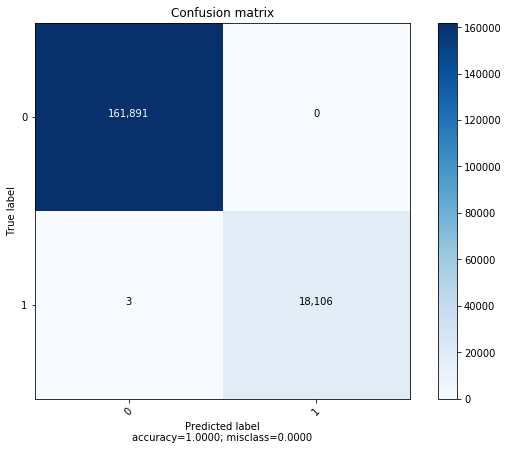

In [168]:
cm = confusion_matrix(y_train, m.predict(X_train))
plot_confusion_matrix(cm,[0,1],normalize=False)

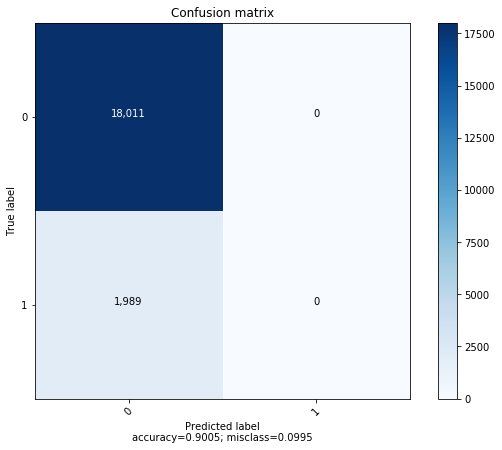

In [169]:
cm = confusion_matrix(y_valid, m.predict(X_valid))
plot_confusion_matrix(cm,[0,1],normalize=False)

#### Try random forest with oversampling and undersampling accordingly since the confusion matrix clearly shows that random forest is failing at imbalanced dataset

In [71]:
x_test = test_data.drop(['ID_code'],axis = 1)
y_test = m.predict(x_test)

In [72]:
submission = pd.DataFrame({"ID_code":test_data["ID_code"],"target":y_test})
submission.to_csv("submission_v2.csv", index=False)

## Trying Xgboost since random forest is failing at Imbalance of dataset

In [172]:
train_columns = train_data.drop(['ID_code','target'],axis =1).columns

In [177]:
xg_train = xgb.DMatrix(X_train[train_columns],label = y_train)
xg_valid = xgb.DMatrix(X_valid[train_columns],label = y_valid)
xg_test = xgb.DMatrix(test_data[train_columns])

In [186]:
param_grid = {'max_depth':3,
                   'silent':1,
                   'eta':0.28071497637474263, # learning rate
                   'gamma':0,
                   'min_child_weight':0.2784483175645849,
                   'objective':'binary:logistic',
                    'eval_metric': 'auc'
                  }
watchlist  = [ (xg_train,'train'),(xg_valid,'eval')]

In [187]:
xgbmodel=xgb.train(params=param_grid,dtrain=xg_train,num_boost_round=500,evals=watchlist,early_stopping_rounds=10)

[0]	train-auc:0.607302	eval-auc:0.603043
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.631256	eval-auc:0.626076
[2]	train-auc:0.660656	eval-auc:0.654385
[3]	train-auc:0.671883	eval-auc:0.66327
[4]	train-auc:0.694132	eval-auc:0.684462
[5]	train-auc:0.704109	eval-auc:0.691484
[6]	train-auc:0.708754	eval-auc:0.695799
[7]	train-auc:0.724452	eval-auc:0.70821
[8]	train-auc:0.735716	eval-auc:0.718275
[9]	train-auc:0.742685	eval-auc:0.724835
[10]	train-auc:0.752532	eval-auc:0.734744
[11]	train-auc:0.760589	eval-auc:0.74443
[12]	train-auc:0.764516	eval-auc:0.750657
[13]	train-auc:0.771262	eval-auc:0.755459
[14]	train-auc:0.775667	eval-auc:0.760641
[15]	train-auc:0.781291	eval-auc:0.765485
[16]	train-auc:0.786808	eval-auc:0.768672
[17]	train-auc:0.79063	eval-auc:0.773334
[18]	train-auc:0.794429	eval-auc:0.776388
[19]	train-auc:0.79899	eval-auc:0.780404
[20]	train-auc:0.801452	eval-auc:0

[191]	train-auc:0.92306	eval-auc:0.878696
[192]	train-auc:0.923201	eval-auc:0.878617
[193]	train-auc:0.923426	eval-auc:0.878696
[194]	train-auc:0.923617	eval-auc:0.878815
[195]	train-auc:0.92376	eval-auc:0.878903
[196]	train-auc:0.923954	eval-auc:0.879049
[197]	train-auc:0.924136	eval-auc:0.879219
[198]	train-auc:0.92428	eval-auc:0.879141
[199]	train-auc:0.9245	eval-auc:0.879224
[200]	train-auc:0.924647	eval-auc:0.879197
[201]	train-auc:0.924752	eval-auc:0.87927
[202]	train-auc:0.924888	eval-auc:0.879545
[203]	train-auc:0.925069	eval-auc:0.879709
[204]	train-auc:0.925339	eval-auc:0.879894
[205]	train-auc:0.925447	eval-auc:0.879893
[206]	train-auc:0.925615	eval-auc:0.879969
[207]	train-auc:0.925763	eval-auc:0.879949
[208]	train-auc:0.925862	eval-auc:0.880227
[209]	train-auc:0.925962	eval-auc:0.880419
[210]	train-auc:0.926083	eval-auc:0.880428
[211]	train-auc:0.926195	eval-auc:0.880453
[212]	train-auc:0.92627	eval-auc:0.880611
[213]	train-auc:0.926452	eval-auc:0.880671
[214]	train-auc:0.

In [190]:
xgbmodel.predict(xg_valid)

array([0.02144288, 0.8751349 , 0.01729539, ..., 0.03742826, 0.02185926,
       0.03580504], dtype=float32)

In [193]:
roc_auc_score(y_valid,xgbmodel.predict(xg_valid))

0.8858627090606241

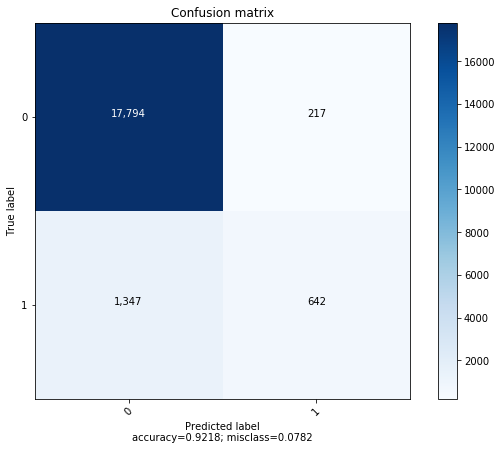

In [194]:
# make predictions for validation data
y_pred = xgbmodel.predict(xg_valid)
predictions = [round(value) for value in y_pred]
cm = confusion_matrix(y_valid, predictions)
plot_confusion_matrix(cm,[0,1],normalize=False)

In [197]:
preds = xgbmodel.predict(xg_test)
dfprediction = test_data[['ID_code']]
dfprediction = dfprediction >> mutate(target = preds)

In [198]:
dfprediction.head()

,ID_code,target
0,test_0,0.086542
1,test_1,0.178134
2,test_2,0.174624
3,test_3,0.182893
4,test_4,0.038063


In [199]:
# Predictions to CSV
dfprediction.to_csv("submission_xgb.csv", index=False)